# Traffic Flow Regression - V3
## - <i>Model Selection</i>
 - this notebook builds upon traffic_flow_regression_V2 but paying closer attention to the model used and optimising this model via hyperparameter tuning
 - see EDA.ipynb for a deeper understanding of the data

# Imports

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Read Dataset
Using dataset created in notebook v2 that has additional feature engineering and integrates multiple data sources

In [16]:
overall_df = pd.read_csv('ml_datasets/v2_dataset.csv')
overall_df.head()

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-04,-6.356151,53.293594,79,1,0,...,0,0.0,0,3.6,0,2.2,-0.3,6.0,75,1003.5
1,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-14,-6.356151,53.293594,58,1,0,...,0,0.0,0,4.1,0,3.5,2.6,7.4,90,1039.5
2,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-21,-6.356151,53.293594,43,1,0,...,0,0.0,0,4.9,0,3.9,2.5,7.3,84,1042.1
3,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-28,-6.356151,53.293594,58,1,0,...,0,0.0,0,2.9,0,2.6,2.0,7.1,93,1035.3
4,00:00,2024-10-12 00:00:00,N01111A,FR,2022-02-18,-6.356151,53.293594,69,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2


## Choose Site
We will start off by just focusing on one site. In our EDA we saw that Site N03121A is isolated so we will choose this one as it is less likely for multicollinearity to occur (where features depend on each other)

In [44]:
df = overall_df[overall_df['site']=='N03121A']
df

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
700,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-04,-6.424314,53.357202,109,1,0,...,0,0.0,0,3.6,0,2.2,-0.3,6.0,75,1003.5
701,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-14,-6.424314,53.357202,97,1,0,...,0,0.0,0,4.1,0,3.5,2.6,7.4,90,1039.5
702,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-21,-6.424314,53.357202,90,1,0,...,0,0.0,0,4.9,0,3.9,2.5,7.3,84,1042.1
703,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-28,-6.424314,53.357202,96,1,0,...,0,0.0,0,2.9,0,2.6,2.0,7.1,93,1035.3
704,00:00,2024-10-12 00:00:00,N03121A,FR,2022-02-18,-6.424314,53.357202,149,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41394,23:30,2024-10-12 23:30:00,N03121A,WE,2022-05-25,-6.424314,53.357202,67,5,23,...,0,0.0,0,10.5,0,9.2,7.9,10.7,84,1016.5
41395,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-04,-6.424314,53.357202,104,6,23,...,0,0.0,0,12.4,0,10.7,9.0,11.5,80,1019.8
41396,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-15,-6.424314,53.357202,68,6,23,...,0,0.0,0,11.3,0,10.9,10.5,12.7,94,1020.9
41397,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-22,-6.424314,53.357202,74,6,23,...,0,0.0,0,16.0,0,14.9,14.1,16.0,88,1012.7


# Machine Learning Workflow
- In this notebook I want to establish a framework for arriving at the best possible model. 
- Lets start by selecting our features

In [45]:
cat_features = ['day', 'time_(hour)']
num_features = ['previous_flow_N01111A','previous_flow_N01131A','previous_flow_N01151A','previous_flow_N02111A','previous_flow_N02131A','previous_flow_N03121A','overall_previous_flow',
    #             'distance_N01111A',
    #    'duration_N01111A', 'distance_N01131A', 'duration_N01131A',
    #    'distance_N01151A', 'duration_N01151A', 'distance_N02111A',
    #    'duration_N02111A', 'distance_N02131A', 'duration_N02131A',
    #    'distance_N03121A', 'duration_N03121A',
       'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum',
       'msl']


## Correlation Matrix of Numerical Features

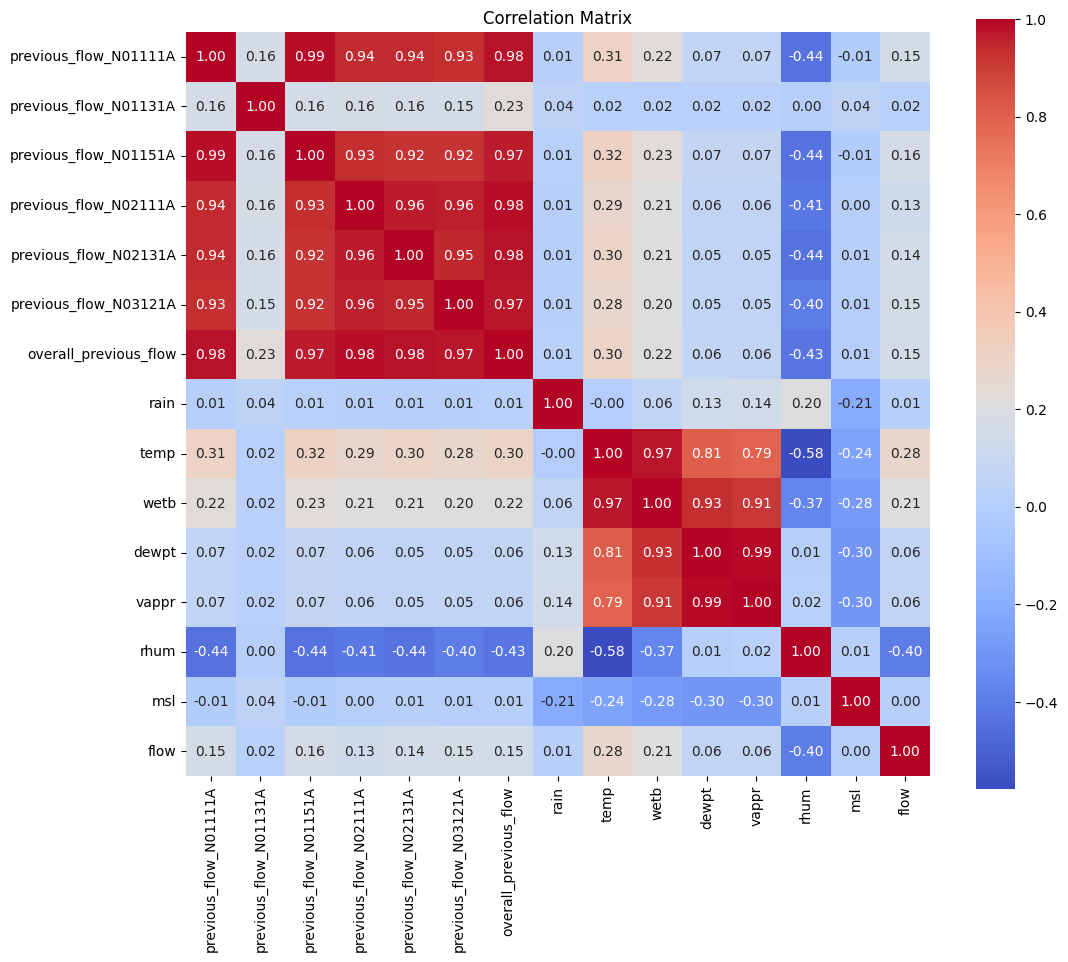

In [46]:
corr_features = num_features+ ['flow']
correlation_matrix = df[corr_features].corr()

# Set the size of the plot
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Show the plot
plt.title('Correlation Matrix')
plt.show()



Observations
- The previous flow at other sites are highly correlated to each other except for 

In [47]:
print(corr_features)

['previous_flow_N01111A', 'previous_flow_N01131A', 'previous_flow_N01151A', 'previous_flow_N02111A', 'previous_flow_N02131A', 'previous_flow_N03121A', 'overall_previous_flow', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'flow']


In [ ]:
include
- seb ratcha 
- applied ml in pyton2, validation curve